In [7]:
import thermo 
import pandas as pd
import numpy as np

# Import the data from the Excel file Amines_train.xlsx and Amines_test.xlsx located in the Data folder
data_train = pd.read_excel('Data/Amines_train.xlsx')
data_test = pd.read_excel('Data/Amines_test.xlsx')
combined_data = pd.concat([data_train, data_test], ignore_index=True)

# Only want to test on the test data after all. 
combined_data = data_test

P2 = 760  # mmHg
R = 8.314  # J/(mol*K)

residuals = []
predicted = []
temperatures = []
true = []
MSE = 0 
count = 0

# Iterate over the rows in combined_data
for row in combined_data.iterrows():
    
    # Calculate the boiling point and heat of vaporization of the molecule using the Joback method
    joback_mol = thermo.group_contribution.joback.Joback(mol=row[1]["SMILES"])
    T2, Hvap = joback_mol.estimate(callables=False)["Tb"], joback_mol.estimate(callables=False)["Hvap"]

    # Iterate over the columns in combined_data
    for column in combined_data.columns:
        if len(column) > 1 and column[1].isnumeric():
            # Print the value in the column for the row
            temperature, pressure = row[1][column].split('=')
            temperature = temperature[2:-2]
            
            # Convert from string to float
            T1 = float(temperature) + 273.15
            pressure_true = float(pressure)

            # Use Clausius-Clapeyron equation to estimate the P1 at T1
            ln_P1 = Hvap/R * (1/T2 - 1/T1) + np.log(P2)

            # Convert from ln to P1
            P1 = np.exp(ln_P1)

            # Convert to log scale
            P1 = np.log10(P1)

            predicted.append(P1)
            true.append(pressure_true)
            temperatures.append(T1 - 273.15)

            # Calculate the residual
            residual = P1 - pressure_true
            residuals.append(residual)

            MSE += residual**2
            count += 1

MSE = MSE/count
RMSE = np.sqrt(MSE)

In [8]:
# For creating the parity plot
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

pd.set_option('display.max_columns', None)

def create_kde_plot(y_hat_values, target_values, temperatures):
    # Calculate the differences between predicted and actual values
    residuals = [y_hat - y_true for y_hat, y_true in zip(y_hat_values, target_values)]

    # Spcify the color of the points based on the temperature.
    temp_colors = []
    residuals_40_to_70 = []
    residuals_70_100 = []
    residuals_100_135 = []
    for i, temp in enumerate(temperatures): 
        if temp < 70:
            temp_colors.append(CB_color_cycle[0])
            residuals_40_to_70.append(residuals[i])
        elif temp < 100:
            temp_colors.append(CB_color_cycle[1])
            residuals_70_100.append(residuals[i])
        else:
            temp_colors.append(CB_color_cycle[2])
            residuals_100_135.append(residuals[i])

    plt.figure(figsize=(12, 6))
    sns.kdeplot(residuals_40_to_70, shade=True, color=CB_color_cycle[0], bw_adjust=0.8, label="40°C-70°C")
    sns.kdeplot(residuals_70_100, shade=True, color=CB_color_cycle[1], bw_adjust=0.8, label="70°C-100°C")
    sns.kdeplot(residuals_100_135, shade=True, color=CB_color_cycle[2], bw_adjust=0.8, label="100°C-135°C")
    #sns.kdeplot(y_hat_values, shade=True, color="r", bw_adjust=0.2)
    #sns.kdeplot(target_values, shade=True, color="b", bw_adjust=0.2)
    #plt.title(f'KDE of LogVP - {title}', fontsize=18)
    plt.xlabel('Residuals (Predicted - True)', fontsize=20)
    plt.ylabel('Density', fontsize=20)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlim(-2, 2)
    plt.legend(loc='upper left', shadow=True, fancybox=True, markerscale=1.5, fontsize=18)
    plt.tight_layout()
    plt.show()
    plt.close()

    plt.figure(figsize=(12, 6))
    #sns.kdeplot(y_hat_values, shade=True, color="r", bw_adjust=0.2)
    sns.kdeplot(residuals, shade=True, color=CB_color_cycle[0], bw_adjust=0.8)
    #plt.title(f'KDE of LogVP - {title}', fontsize=18)
    plt.xlabel('Residuals (Predicted - True)', fontsize=20)
    plt.ylabel('Density', fontsize=20)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    #plt.legend(loc='upper left', shadow=True, fancybox=True, markerscale=1.5)
    plt.tight_layout()

    # Calculate the 95% confidence interval
    lower_bound = np.percentile(residuals, 5)
    upper_bound = np.percentile(residuals, 95)

    plt.xlim(-2, 2)

    # Annotate the 95% confidence interval on the plot
    plt.axvline(lower_bound, color='black', linestyle='--', linewidth=1.5, label=f'5th percentile: {lower_bound:.2f}')
    plt.axvline(upper_bound, color='black', linestyle='--', linewidth=1.5, label=f'95th percentile: {upper_bound:.2f}')
    plt.legend(loc='upper left', shadow=True, fancybox=True, markerscale=1.5, fontsize=18)
    plt.show()
    plt.close()


def create_parity_plot(y_hat_values, target_values, temperatures):
    # Plotting the parity line (identity line), that represents a perfect fit. To do this, we need to find the
    # maximum y value (can either be from the actual y value or the predicted value). We also need the minimum value.
    max_val = max(max(y_hat_values), max(target_values))
    min_val = min(min(y_hat_values), min(target_values))

    X_val_list = [-1.5, 4]
    y_val_list = [-1.5, 4]

    # Create a line between the minimum value and the maximum value. Note that here we have a list of X -values and lis
    plt.figure()
    # Want the x-axis and y-axis numbers to be larger so it becomes easier to read
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    # Want to rotate the x-axis labels by 90 degrees so they don't overlap
    plt.xticks(rotation=45)

    plt.xlim(-1.5, 4)
    plt.ylim(-1.5, 4)

    # Spcify the color of the points based on the temperature.
    temp_colors = []
    target_40_to_70 = []
    target_70_100 = []
    target_100_135 = []
    predicted_40_to_70 = []
    predicted_70_100 = []
    predicted_100_135 = []
    for index, temp in enumerate(temperatures): 
        if temp < 70:
            temp_colors.append(CB_color_cycle[0])
            target_40_to_70.append(target_values[index])
            predicted_40_to_70.append(y_hat_values[index])
        elif temp < 100:
            temp_colors.append(CB_color_cycle[1])
            target_70_100.append(target_values[index])
            predicted_70_100.append(y_hat_values[index])
        else:
            temp_colors.append(CB_color_cycle[2])
            target_100_135.append(target_values[index])
            predicted_100_135.append(y_hat_values[index])

    # Scatter plot of predicted vs. actual values with temperature color coding
    plt.scatter(target_values, y_hat_values, c=temp_colors, alpha=0.9, edgecolors='w', s=40)
    
    plt.plot(X_val_list, y_val_list, 'k--')
    # Have to label the colors manually
    plt.scatter([], [], c=CB_color_cycle[0], label="40°C-70°C", alpha=0.7, edgecolors='w', s=40)
    plt.scatter([], [], c=CB_color_cycle[1], label="70°C-100°C", alpha=0.7, edgecolors='w', s=40)
    plt.scatter([], [], c=CB_color_cycle[2], label="100°C-135°C", alpha=0.7, edgecolors='w', s=40)
    plt.legend(loc='upper left', shadow=True, fancybox=True, markerscale=1.5)

    # Creates title and labels
    plt.xlabel('True', fontsize=18)
    plt.ylabel('Predicted', fontsize=18)
    #plt.title(f"Parity Plot - {train_test_val}", fontsize=18)
    plt.show()
    plt.close()

    # Also make three individual parity plots for each temperature range.
    plt.figure()
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xticks(rotation=45)
    plt.scatter(target_40_to_70, predicted_40_to_70, c=CB_color_cycle[0], alpha=0.7, edgecolors='w', s=40, label="40°C-70°C")
    plt.plot(X_val_list, y_val_list, 'k--')
    plt.xlabel('True', fontsize=18)
    plt.ylabel('Predicted', fontsize=18)
    #plt.title(f"Parity Plot - 40°C-70°C - {train_test_val}", fontsize=18)
    plt.legend(loc='upper left', shadow=True, fancybox=True, markerscale=1.5)
    plt.tight_layout()
    plt.show()
    plt.close()

    plt.figure()
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xticks(rotation=45)
    plt.scatter(target_70_100, predicted_70_100, c=CB_color_cycle[1], alpha=0.7, edgecolors='w', s=40, label="70°C-100°C")
    plt.plot(X_val_list, y_val_list, 'k--')
    plt.xlabel('True', fontsize=18)
    plt.ylabel('Predicted', fontsize=18)
    #plt.title(f"Parity Plot - 70°C-100°C - {train_test_val}", fontsize=18)
    plt.legend(loc='upper left', shadow=True, fancybox=True, markerscale=1.5)
    plt.tight_layout()
    plt.show()
    plt.close()

    plt.figure()
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xticks(rotation=45)
    plt.scatter(target_100_135, predicted_100_135, c=CB_color_cycle[2], alpha=0.7, edgecolors='w', s=40, label="100°C-135°C")
    plt.plot(X_val_list, y_val_list, 'k--')
    plt.xlabel('True', fontsize=18)
    plt.ylabel('Predicted', fontsize=18)
    #plt.title(f"Parity Plot - 100°C-135°C - {train_test_val}", fontsize=18)
    plt.legend(loc='upper left', shadow=True, fancybox=True, markerscale=1.5)
    plt.tight_layout()
    plt.show()
    plt.close()

## Riedel model

In [9]:
from math import log
from math import exp

# All functions are extracted from the paper https://doi.org/10.1016/j.fluid.2005.12.018

def PLXANT_PCES(Tb, Tc, Pc):
    # Tb: boiling temperature (C)
    # Tc: critical temperature (C)
    # Pc: critical pressure (bar)
    
    Tb = Tb + 273.15    # C to K
    Tc = Tc + 273.15    # C to K
    Tbr = Tb / Tc

    K = 0.0838
    PSI = -35 + 36 / Tbr + 42 * log(Tbr) - Tbr**6
    alpha = (3.758 * K * PSI + log(Pc / 1.01325)) / (K * PSI - log(Tbr))
    
    Q = K * (3.758 - alpha)
    A = -35 * Q
    B = -36 * Q
    C = 42 * Q + alpha
    D = -Q
    
    C1 = A + log(Pc) - C * log(Tc)
    C2 = -B * Tc
    C3 = 0
    C4 = 0
    C5 = C
    C6 = D / Tc**6
    C7 = 6
    C8 = Tb - 273.15
    C9 = Tc - 273.15
    C = [C1, C2, C3, C4, C5, C6, C7, C8, C9]
    
    return C


def RIEDEL(T, Tb, Tc, Pc):
    # T : temperature (C)
    # Tb: boiling temperature (C)
    # Tc: critical temperature (C)
    # Pc: critical pressure (bar)

    # C to K
    T = T + 273.15    
    Tb = Tb + 273.15
    Tc = Tc + 273.15
    
    Tbr = Tb / Tc
    Tr = T / Tc

    K = 0.0838
    PSIb = -35 + 36 / Tbr + 42 * log(Tbr) - Tbr**6
    alphac = (3.758 * K * PSIb + log(Pc / 1.01325)) / (K * PSIb - log(Tbr))
    
    Q = K * (3.758 - alphac)
    A = -35 * Q
    B = -36 * Q
    C = 42 * Q + alphac
    D = -Q

    lnPLr = A - B / Tr + C * log(Tr) + D * Tr**6
    PLr = exp(lnPLr)
    PL = PLr * Pc
    
    return PL

## Extended Antoine

In [10]:
# Also extracted from the paper 

def PLXANT(T, C):
    if T < C[7]:
        dT = 1E-5
        PLmin1 = PLXANT(C[7], C)
        PLmin2 = PLXANT(C[7] + dT, C)
        slope = (log(PLmin1) - log(PLmin2)) / ((1 / ((C[7] + dT) + 273.15)) - (1 / (C[7] + 273.15)))
        lnPL = log(PLmin1) + slope * ((1 / (C[7] + 273.15)) - (1 / (T + 273.15)))
        
    if T > C[8]:
        dT = 1E-5
        PLmax1 = PLXANT(C[8] - dT, C)
        PLmax2 = PLXANT(C[8], C)
        slope = (log(PLmax1) - log(PLmax2)) / ((1 / (C[8] + 273.15)) - (1 / ((C[8] - dT) +273.15)))
        lnPL = log(PLmax2) + slope * ((1 / (C[8] + 273.15)) - (1 / (T + 273.15)))
        lnPLmax = 7 + log(PLXANT(C[8], C))
        lnPL = min(lnPL,lnPLmax)
        
    if T >= C[7] and T <= C[8]:
        lnPL = C[0] + C[1] / ((T + 273.15) + C[2]) + C[3] * (T + 273.15) + C[4] * log((T + 273.15)) + C[5] * (T + 273.15)**C[6]
        
    PL = exp(lnPL)
    return PL

In [11]:
import thermo 
import pandas as pd
import numpy as np

# Import the data from the Excel file Amines_train.xlsx and Amines_test.xlsx located in the Data folder
data_train = pd.read_excel('Data/Amines_train.xlsx')
data_test = pd.read_excel('Data/Amines_test.xlsx')
combined_data = pd.concat([data_train, data_test], ignore_index=True)

# Only want to test on the test data after all. 
combined_data = data_test

R = 8.314  # J/(mol*K)

residuals = []
predicted = []
temperatures = []
true = []
MSE = 0 
count = 0

# Iterate over the rows in combined_data
for row in combined_data.iterrows():
    
    # Calculate the boiling point and heat of vaporization of the molecule using the Joback method
    joback_mol = thermo.group_contribution.joback.Joback(mol=row[1]["SMILES"])
    Tb, Tc, Pc = joback_mol.estimate(callables=False)["Tb"], joback_mol.estimate(callables=False)["Tc"], joback_mol.estimate(callables=False)["Pc"]

    # Convert from C to K
    Tb = Tb - 273.15
    Tc = Tc - 273.15

    # Convert Pc from Pa to bar 
    Pc = Pc / 100000

    # Extended Antoine equation parameters for vapor pressure
    extended_antione_parameters = PLXANT_PCES(Tb, Tc, Pc)    

    # Iterate over the columns in combined_data
    for column in combined_data.columns:
        if len(column) > 1 and column[1].isnumeric():
            # Print the value in the column for the row
            temperature, pressure = row[1][column].split('=')
            temperature = temperature[2:-2]
            
            # Convert from string to float
            T1 = float(temperature)
            pressure_true = float(pressure)

            # Estimate pressure in bar
            P1 = PLXANT(T1, extended_antione_parameters)

            # Convert to mmHg
            P1 = P1 * 750.0616827

            # Convert to log scale
            P1 = np.log10(P1)

            # Append the values to the lists
            predicted.append(P1)
            true.append(pressure_true)
            temperatures.append(T1)

            # Calculate the residual
            residual = P1 - pressure_true
            residuals.append(residual)

            MSE += residual**2
            count += 1

MSE = MSE/count
RMSE = np.sqrt(MSE)

Root Mean Squared Error:  0.5807235964004659


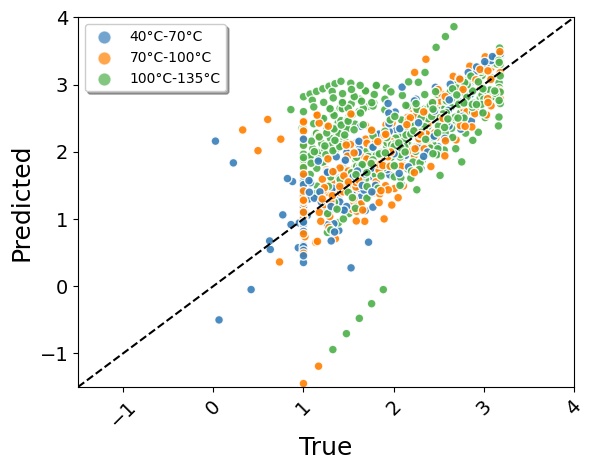

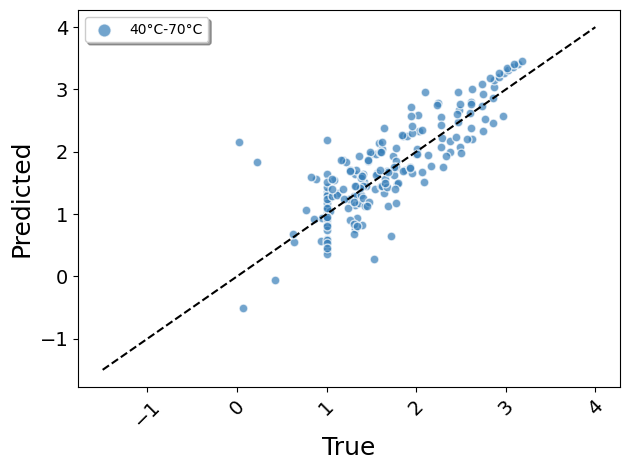

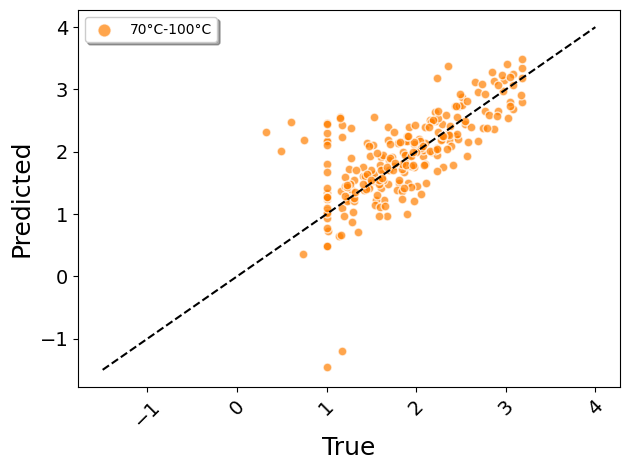

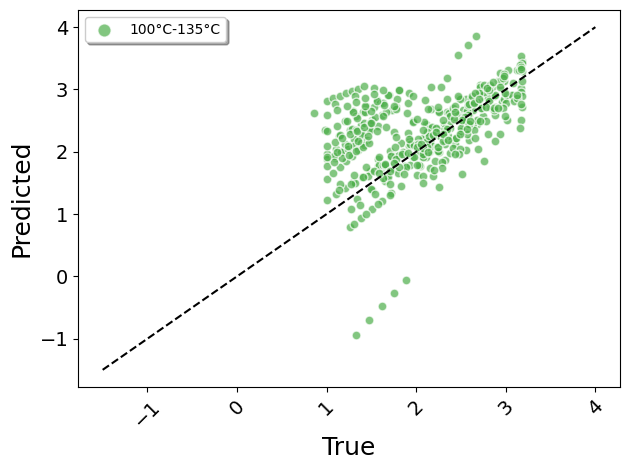

/var/folders/sb/xp5jwlt55878lf0mfpdf0y2r0000gn/T/ipykernel_51468/1827594270.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(residuals_40_to_70, shade=True, color=CB_color_cycle[0], bw_adjust=0.8, label="40°C-70°C")
/var/folders/sb/xp5jwlt55878lf0mfpdf0y2r0000gn/T/ipykernel_51468/1827594270.py:34: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(residuals_70_100, shade=True, color=CB_color_cycle[1], bw_adjust=0.8, label="70°C-100°C")
/var/folders/sb/xp5jwlt55878lf0mfpdf0y2r0000gn/T/ipykernel_51468/1827594270.py:35: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(residuals_100_135, shade=True, color=CB_color_cycle[2], bw_a

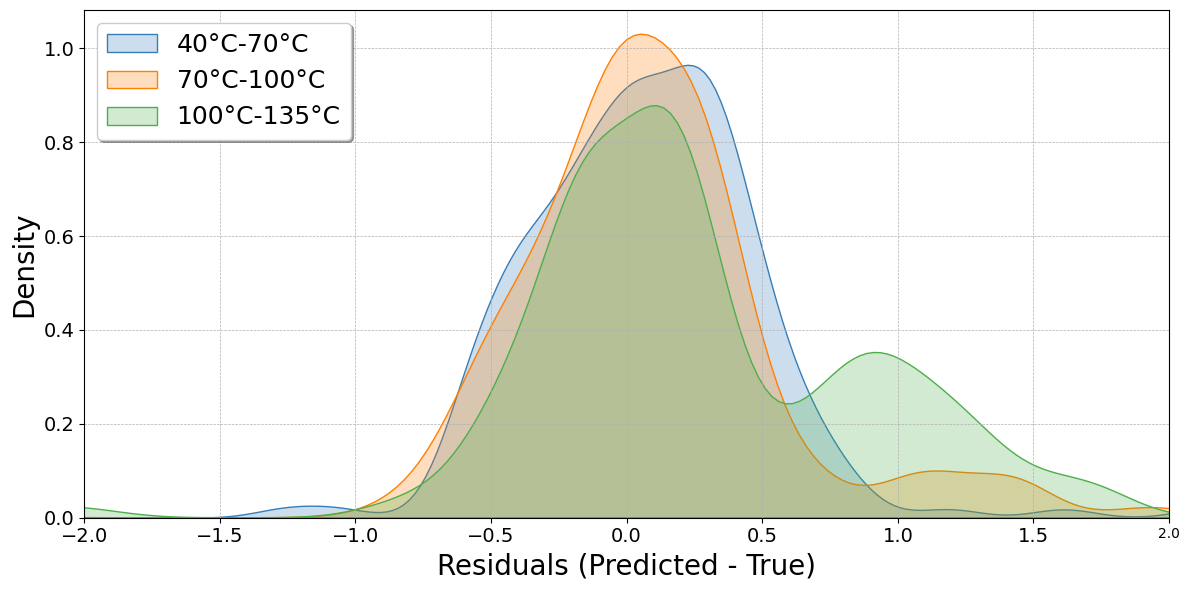

/var/folders/sb/xp5jwlt55878lf0mfpdf0y2r0000gn/T/ipykernel_51468/1827594270.py:52: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(residuals, shade=True, color=CB_color_cycle[0], bw_adjust=0.8)


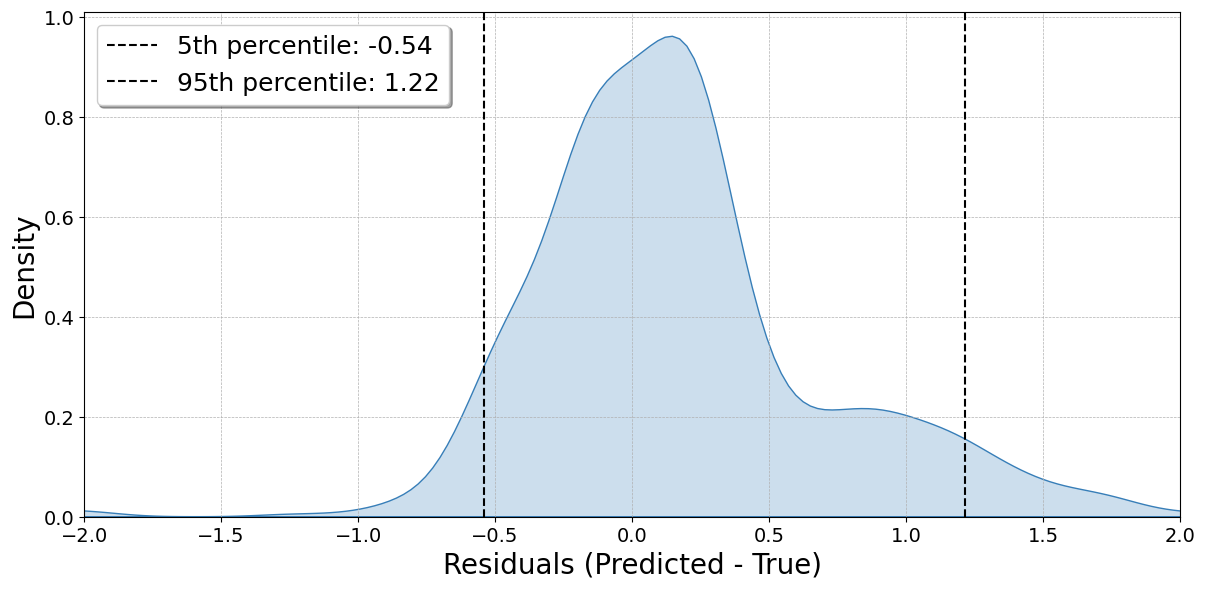

In [12]:
print("Root Mean Squared Error: ", RMSE)
create_parity_plot(predicted, true, temperatures)
create_kde_plot(predicted, true, temperatures)
